In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras import Sequential
from sklearn.model_selection import train_test_split
from keras.src.layers import LSTM, Dense
import joblib

In [2]:
def get_df(data_size:int=10000, path:str="AAPL_stock_prices.csv", delimeter: str = ',', from_end: bool = True, date_column: str = 'Date', target_column: str = 'Close') -> tuple[np.ndarray, MinMaxScaler, int]:
    df = pd.read_csv(path, delimiter=delimeter)
    df = df.iloc[-data_size:, :] if from_end else df.iloc[:data_size, :]
    dates = pd.to_datetime(df[date_column])
    df.drop(columns=[date_column], inplace=True)
    df.index = dates # type: ignore
    target_column_index = df.columns.tolist().index(target_column)
    print(df)
    try: 
        scaler = joblib.load('scaler.gz')
    except:
        scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler, target_column_index

scaled_data, scaler, target_column_index = get_df()



                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1984-09-27    0.114955    0.115513    0.114955    0.114955    0.088721   
1984-09-28    0.114955    0.114955    0.109933    0.112165    0.086568   
1984-10-01    0.111607    0.111607    0.109375    0.109375    0.084415   
1984-10-02    0.110491    0.114397    0.110491    0.110491    0.085276   
1984-10-03    0.112165    0.113839    0.112165    0.112165    0.086568   
...                ...         ...         ...         ...         ...   
2024-05-28  191.509995  193.000000  189.100006  189.990005  189.990005   
2024-05-29  189.610001  192.250000  189.509995  190.289993  190.289993   
2024-05-30  190.759995  192.179993  190.630005  191.289993  191.289993   
2024-05-31  191.440002  192.570007  189.910004  192.250000  192.250000   
2024-06-03  192.899994  194.990005  192.520004  194.029999  194.029999   

               Volume  
Date         

In [3]:
def get_df(df: pd.DataFrame, scaler = None, target_column: str = 'Close'):
    target_column_index = df.columns.tolist().index(target_column)
    if scaler is None:
        try: 
            scaler = joblib.load('scaler.gz')
        except:
            scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    return scaled_data, target_column_index

In [4]:
def create_dataset(data: np.ndarray, time_step: int=10):
    X, Y = [], []
    for i in range(len(data) - time_step):
        # Define the range of input sequences
        end_ix = i + time_step
        
        # Define the range of output sequences
        out_end_ix = end_ix + 1
        
        # Ensure that the dataset is within bounds
        if out_end_ix > len(data)-1:
            break
            
        # Extract input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix], data[out_end_ix]
        
        # Append the parts
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y), data.shape[1], time_step


X, Y, feature_number, time_step = create_dataset(data=scaled_data)

(9989, 10, 6)
(9989, 6)


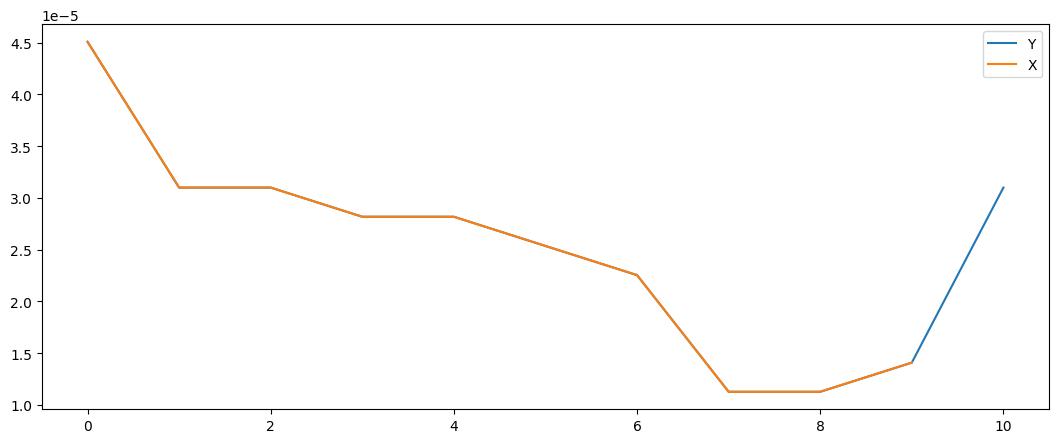

In [5]:
# Plot X and Y
print(X.shape)
print(Y.shape)
for i in range(250,251):
    plot_X, plot_all = [], []
    for value in range(X.shape[1]):
      plot_X.append(X[i, value, target_column_index])
      plot_all.append(X[i, value, target_column_index])
    plot_all.append(Y[i, target_column_index])

    plt.figure(figsize=(13, 5))
    plt.plot(plot_all, label='Y')
    plt.plot(plot_X, label='X')
    plt.legend()
    plt.show()

In [6]:
# # Split the data into training and testing sets
# train_size = int(len(X) * 0.8)
# test_size = len(X) - train_size
# X_train, X_test = X[0:train_size], X[train_size:len(X)]
# Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [28]:
# Split the data: 70% training, 15% validation, 15% testing
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [8]:
print(f"{X_train.shape=}, {Y_train.shape=}")
print(f"{X_test.shape=}, {Y_test.shape=}")
print(X_train[:1, 0, :])
print(X_test[:1, 0, :])
print(Y_train[:1, :])
print(Y_test[:1, :])

X_train.shape=(6992, 10, 6), Y_train.shape=(6992, 6)
X_test.shape=(1499, 10, 6), Y_test.shape=(1499, 6)
[[0.00679663 0.00681989 0.006802   0.00684683 0.00582763 0.05305258]]
[[0.00180135 0.00180648 0.00176816 0.00175825 0.00144566 0.01661301]]
[[0.00641775 0.00636352 0.00611287 0.00613091 0.0052208  0.09118665]]
[[0.00163221 0.0016387  0.00162082 0.00162864 0.00134007 0.00759474]]


In [9]:
def create_model(input_shape: tuple, layers_with_units: list[int] = [128,128,64], optimizer: str = 'adam', loss: str = 'mean_squared_error', metrics: list[str]=['mse', 'mape']) -> Sequential:
    # Create the LSTM model
    model = Sequential()
    for layer in layers_with_units[:-1]:
        model.add(LSTM(layer, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(layers_with_units[-1], return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer = optimizer, loss = loss, metrics=metrics)
    return model

In [10]:
EPOCH: int = 50
BATCH_SIZE: int = 1
LAYERS: list[int] = [256,256]
OPTIMIZER: str = 'adam'
LOSS: str = 'mean_squared_error'
METRICS: list[str] = ['mse']

In [11]:
model = create_model(input_shape=(X_train.shape[1], feature_number), layers_with_units=LAYERS, optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

c:\Users\orhun\.conda\envs\stockprice\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/50
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 174s 24ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 2/50
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 165s 24ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 3/50
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 163s 23ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 4/50
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 165s 24ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 5/50
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 165s 24ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 6/50
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 165s 24ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 7/50
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 164s 23ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 8/50
6992/6992 ━━━━━━━━━━━━━━━━━━━━ 165s 24ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 9/50
6992/

In [22]:
loss_eval, mae = model.evaluate(X_val, Y_val)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0090 - mse: 0.0090


In [ ]:
# # Plot training & validation loss values
# print(history.history.keys())
# other_keys: list = []
# for value in history.history.keys() :
#     plt.plot(history.history[value], label=value.replace('_', ' ').capitalize()) if not 'loss' in value and not 'acc' in value else other_keys.append(value)
#     plt.title('Errors')
#     plt.ylabel(value.replace('_', ' ').capitalize())
#     plt.xlabel('Epoch')
#     plt.legend()
#     plt.show()
# for value in other_keys :
#     plt.plot(history.history[value], label=value.replace('_', ' ').capitalize())
#     plt.title('Model loss')
#     plt.ylabel(value.replace('_', ' ').capitalize())
#     plt.xlabel('Epoch')
#     plt.legend()
#     plt.show()

In [29]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [30]:
print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")
# print(train_predict[:2, :])

train_predict.shape=(6992, 1), test_predict.shape=(1499, 1), Y_train.shape=(6992, 6), Y_test.shape=(1499, 6)


In [31]:
# Inverse transform the predictions
def update_data_to_inverse(predicted_data: np.ndarray, scaler: MinMaxScaler, target_column_index: int, feature_number: int):
    new_dataset = np.zeros(shape=(len(predicted_data), feature_number))
    new_dataset[:,target_column_index] = predicted_data.flatten()
    return scaler.inverse_transform(new_dataset)[:, target_column_index].reshape(-1, 1)

In [32]:
train_predict = update_data_to_inverse(predicted_data=train_predict, scaler=scaler, target_column_index=target_column_index, feature_number=feature_number)
test_predict = update_data_to_inverse(predicted_data=test_predict, scaler=scaler, target_column_index=target_column_index, feature_number=feature_number)
Y_train = scaler.inverse_transform(Y_train)
Y_test = scaler.inverse_transform(Y_test)

print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")
print(train_predict[:2, :])

train_predict.shape=(6992, 1), test_predict.shape=(1499, 1), Y_train.shape=(6992, 6), Y_test.shape=(1499, 6)
[[3.3588463 ]
 [0.97661738]]


In [33]:
# Calculate MSE
train_mse = mean_squared_error(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
test_mse = mean_squared_error(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

# Calculate R2 score
train_r2 = r2_score(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
test_r2 = r2_score(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train R2 Score: {train_r2:.4f}, Test R2 Score: {test_r2:.4f}")
print(f"\nTrue - Y_train[5:10, target_column_index].reshape(-1, 1)\n{Y_train[5:10, target_column_index].reshape(-1, 1)}\n\nPredicted - train_predict[5:10]\n{train_predict[5:10]}")

Train MSE: 76.5495, Test MSE: 72.4449
Train R2 Score: 0.9646, Test R2 Score: 0.9642

True - Y_train[5:10, target_column_index].reshape(-1, 1)
[[155.33000183]
 [129.61000061]
 [  0.46540201]
 [  3.42428589]
 [  0.52901798]]

Predicted - train_predict[5:10]
[[128.49273787]
 [108.18172593]
 [  1.00380886]
 [  8.68900429]
 [  0.73683424]]


In [34]:
def log(epoch, layers_with_units, optimizer, loss, train_mse = None, train_r2 = None, y_true = None, train_predict = None):
    with open('log.txt', 'a') as file:
        file.write(f"Train Results with Epoch - {epoch}:")
        if y_true and train_predict:
            file.write(f"\nY_True:\n{y_true}\nY_Predicted\n{train_predict}")        
        file.write(f"\n    Layers: {layers_with_units}")
        file.write(f"\n    Optimizer : {optimizer}")
        file.write(f"\n    Loss: {loss}")
        file.write(f"\n    Evaluations -> Loss_{loss} Mae_{mae}")
        file.write(f"\n    Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
        file.write(f"\n    Train R2 Score: {train_r2:.4f}, Test R2 Score: {test_r2:.4f}\n\n")

In [20]:
# log(epoch=EPOCH, layers_with_units=LAYERS, optimizer=OPTIMIZER, loss=LOSS, train_mse=train_mse, train_r2=train_r2, y_true=Y_train[5:10, target_column_index].reshape(-1, 1), train_predict=train_predict[5:10])
log(epoch=EPOCH, layers_with_units=LAYERS, optimizer=OPTIMIZER, loss=LOSS, train_mse=train_mse, train_r2=train_r2)

time_step=10, X.shape=(9989, 10, 6), (len(train_predict) + time_step)=7002
test_predict.shape=(1499, 1), train_predict.shape=(6992, 1), scaled_data.shape=(10000, 6)


ValueError: could not broadcast input array from shape (1499,1) into shape (2997,1)

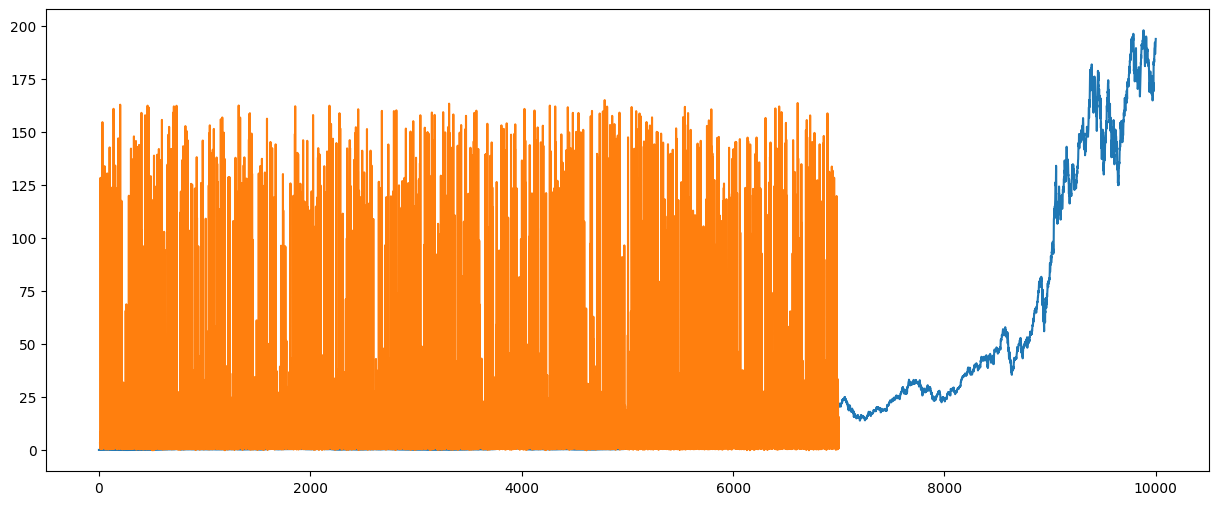

In [35]:
print(f"{time_step=}, {X.shape=}, {(len(train_predict) + time_step)=}")
print(f"{test_predict.shape=}, {train_predict.shape=}, {scaled_data.shape=}")

# Plot the predictions
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_data)[:, target_column_index], label='Original Data')
train_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(train_predict_plot, label='Training Predictions')

test_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + time_step:len(scaled_data[:, target_column_index]) - 1, :] = test_predict
plt.plot(test_predict_plot, label='Testing Predictions')

plt.title('Time Series Prediction')
plt.legend()
plt.show()

In [ ]:
joblib.dump(scaler, 'scaler.gz')

In [ ]:
model.save('lstm_model_test.keras')

In [ ]:
# # Load the saved model
# loaded_model = load_model('lstm_model.h5')

In [ ]:
# # Assuming `X_new` and `Y_new` are new data arrays
# history_updated = loaded_model.fit(X_new, Y_new, epochs=50, batch_size=1, verbose=1)

# # Save the updated model
# loaded_model.save('updated_lstm_model.h5')